# **IMPORTADO DE MÓDULOS/FUNCIONES/DATA**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


import tensorflow as tf
tf.version.VERSION
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from keras.regularizers import l2

2024-08-04 00:21:12.570051: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-04 00:21:12.595703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 00:21:12.972315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from functions import momentos, gauss, gauss_fit, get_mean_pulse_from_set, delay_pulse_pair, move_to_reference, create_and_delay_pulse_pair, create_position, calculate_gaussian_center_sigma, normalize, plot_gaussian_and_get_params, normalize_given_params, set_all_seeds
from Models import model_definition

In [3]:
#data = np.load('/home/josea/pulsos_Na22_filt_norm_practica_polyfit.npz')['data']
data = np.load('/home/josea/PRUEBA_Co60.npz')['data']

## **INTERPOLATE**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
EXTRASAMPLING = 8
Nt = np.shape(data)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func = interp1d(tiempo, data,  kind = 'cubic', axis = 1)
new_data = interp_func(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

#-------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_data[:,:,1] = np.roll(new_data[:,:,1], align_steps)
new_data[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)


Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


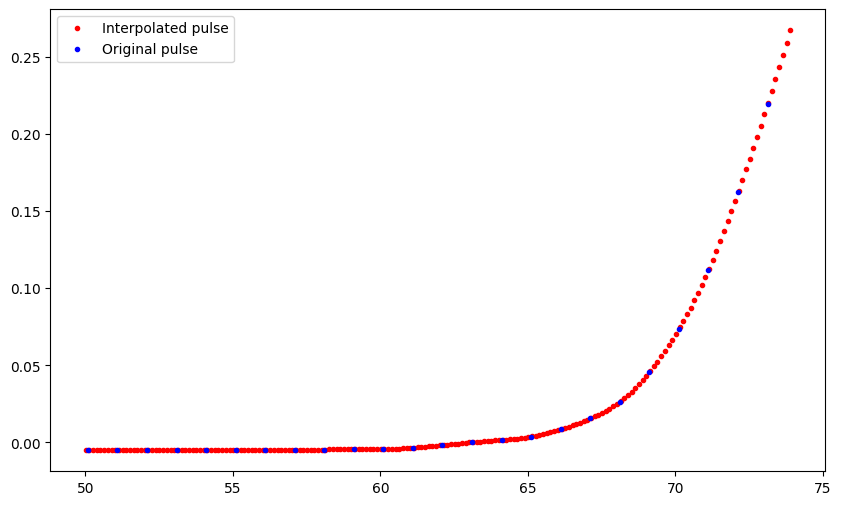

In [5]:
start = 50*EXTRASAMPLING
stop = 74*EXTRASAMPLING

plt.figure(figsize = (10,6))

plt.plot(tiempo_new[start:stop],new_data[0,start:stop,0],'r.')
plt.plot(tiempo[50:74], data[0,50:74,0],'b.')
plt.legend(('Interpolated pulse','Original pulse'))

# **DEFINITIONS**

In [6]:
Ajuste_grueso = 1  # 0 = YES, 1 = NO
delay_steps = 30  # Max number of steps to delay pulses
moments_order = 5  # Max order of moments used
nbins = 51 #Num bins for all histograms
create_positions = 1 # Wether to create new_source positions. (0 = YES, 1 = NO)                           
t_shift = 8 #Time steps to move for the new positions
epochs = 100 
normalization_method = 'min-max'
set_all_seeds(seed = 42)
Num_Neurons = 128

# Train/test set split
train_data = new_data[:3800,:,:] #3800
test_data = new_data[3800:,:,:] 
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  3800
Número de casos de test:  656


# **DETECTORS**

In [7]:
# Create train set
if Ajuste_grueso == 0:
    
    # Calculate mean pulse in detector 
    mean_dec0 = get_mean_pulse_from_set(train_data, channel = 0)
    mean_dec1 = get_mean_pulse_from_set(train_data, channel = 1)

    # Move rest of the pulses to align with mean 
    delays_dec0, moved_pulses_dec0 = move_to_reference(mean_dec0, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays_dec1, moved_pulses_dec1 = move_to_reference(mean_dec1, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 1)

   
    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = delay_steps, NOISE = False)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = delay_steps, NOISE = False)

if Ajuste_grueso == 1:
    

    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,start:stop,0], new_time_step, delay_steps = delay_steps, NOISE = False)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,start:stop,1], new_time_step, delay_steps = delay_steps, NOISE = False)

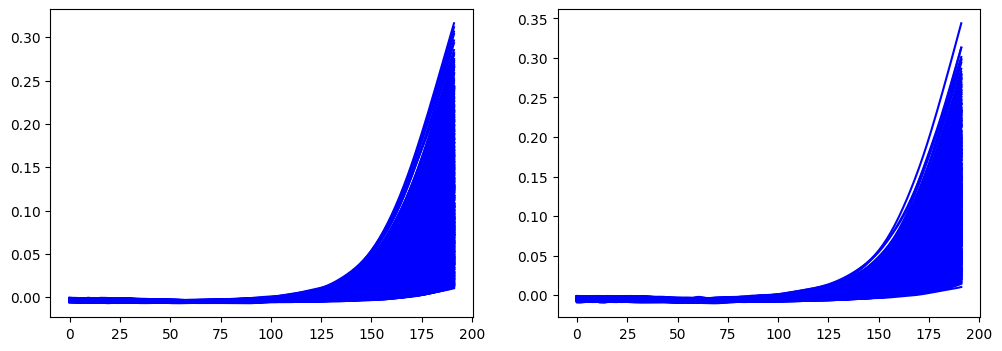

In [8]:
# Plot
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(1000):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.subplot(122)
for i in range(1000):
    plt.plot(trainX_dec1[i,:,0],'b-')

In [9]:
#-------------------------------------------------------------- Calculate moments ------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order)
M_Train_dec1 = momentos(trainX_dec1, order = moments_order)

#-------------------------------------------------------------- Normalize ---------------------------------------------------
M_Train_dec0, params_dec0 =  normalize(M_Train_dec0, method = normalization_method)
M_Train_dec1, params_dec1 =  normalize(M_Train_dec1, method = normalization_method)

#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Normalization parameters detector 0:", params_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Normalization parameters detector 1:", params_dec1)

(3800, 5, 2) NM = 5
Normalization parameters detector 0: (array([-0.59037584, -0.21703806, -0.08446715, -0.02463465,  0.00732137]), array([9.21233292, 8.53048929, 7.76744566, 7.09737441, 6.52248194]))
(3800, 5, 2) NM = 5
Normalization parameters detector 1: (array([-0.75035392, -0.27204374, -0.11697501, -0.04513164, -0.0047014 ]), array([8.20157933, 7.71131143, 7.06060839, 6.47540144, 5.96932863]))


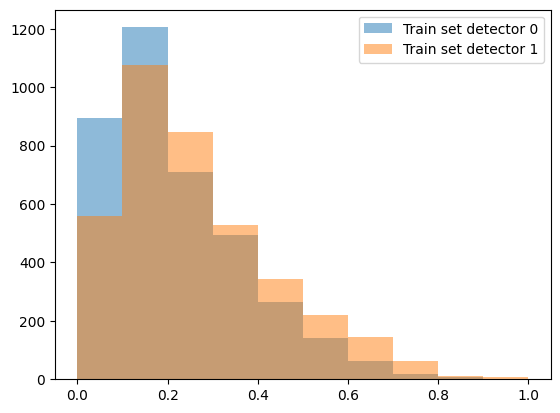

In [10]:
plt.hist(M_Train_dec0[:,0,0], alpha = 0.5, label = 'Train set detector 0');
plt.hist(M_Train_dec1[:,0,0], alpha = 0.5, label = 'Train set detector 1');
plt.legend()

# **FULL TOF**

In [11]:
REFERENCE_PULSE_dec0 = np.tile(train_data[0,start:stop,0], (test_data.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(train_data[0,start:stop,1], (test_data.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0, moments_order)
M_REF_dec1 = momentos(REFERENCE_PULSE_dec1, moments_order)

M_REF_dec0 = normalize_given_params(M_REF_dec0, params_dec0, channel = 0, method = normalization_method)
M_REF_dec1 = normalize_given_params(M_REF_dec1, params_dec1, channel = 0, method = normalization_method)

#-------------------------------- Create test set ---------------------------------------------------------
if Ajuste_grueso == 0:
    
    delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_dec0, test_data, start = start, stop = stop, max_delay = int(stop - start), channel = 0)
    delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_dec1, test_data, start = start, stop = stop, max_delay = int(stop - start), channel = 1)
 
    TEST_00 = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
    TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
    TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
    TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
    TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)

if Ajuste_grueso == 1:
    
    TEST_00 = test_data[:,start:stop,:]
    TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
    TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
    TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
    TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)


M_Test_00 = momentos(TEST_00, order = moments_order)
M_Test_00_dec0 = normalize_given_params(M_Test_00, params_dec0, channel = 0, method = normalization_method)
M_Test_00_dec1 = normalize_given_params(M_Test_00, params_dec1, channel = 1, method = normalization_method)
M_Test_00 = np.stack((M_Test_00_dec0, M_Test_00_dec1), axis = -1)

M_Test_02 = momentos(TEST_02, order = moments_order)
M_Test_02_dec0 = normalize_given_params(M_Test_02, params_dec0, channel = 0, method = normalization_method)
M_Test_02_dec1 = normalize_given_params(M_Test_02, params_dec1, channel = 1, method = normalization_method)
M_Test_02 = np.stack((M_Test_02_dec0, M_Test_02_dec1), axis = -1)

M_Test_20 = momentos(TEST_20, order = moments_order)
M_Test_20_dec0 = normalize_given_params(M_Test_20, params_dec0, channel = 0, method = normalization_method)
M_Test_20_dec1 = normalize_given_params(M_Test_20, params_dec1, channel = 1, method = normalization_method)
M_Test_20 = np.stack((M_Test_20_dec0, M_Test_20_dec1), axis = -1)

M_Test_04 = momentos(TEST_04, order = moments_order)
M_Test_04_dec0 = normalize_given_params(M_Test_04, params_dec0, channel = 0, method = normalization_method)
M_Test_04_dec1 = normalize_given_params(M_Test_04, params_dec1, channel = 1, method = normalization_method)
M_Test_04 = np.stack((M_Test_04_dec0, M_Test_04_dec1), axis = -1)

M_Test_40 = momentos(TEST_40, order = moments_order)
M_Test_40_dec0 = normalize_given_params(M_Test_40, params_dec0, channel = 0, method = normalization_method)
M_Test_40_dec1 = normalize_given_params(M_Test_40, params_dec1, channel = 1, method = normalization_method)
M_Test_40 = np.stack((M_Test_40_dec0, M_Test_40_dec1), axis = -1)

In [12]:
model_dec0 = model_definition(NM = NM, NN = Num_Neurons, STD_INIT = 0.5)
model_dec1 = model_definition(NM = NM, NN = Num_Neurons, STD_INIT = 0.5)
  
opt_dec0 = tf.keras.optimizers.AdamW(learning_rate = 1e-4)
opt_dec1 = tf.keras.optimizers.AdamW(learning_rate = 1e-4)

model_dec0.compile(optimizer = opt_dec0,loss = 'MSE')
model_dec1.compile(optimizer = opt_dec1,loss = 'MSE')


loss_dec0 = []
loss_dec1 = []
TOFN_02_epoch = []
TOFN_00_epoch = []
TOFN_20_epoch = []
TOFN_04_epoch = []
TOFN_40_epoch = []



for epoch in range(epochs):
     
  history_dec0 = model_dec0.fit(x = [M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]], y = REF_train_dec0, epochs = 15, batch_size = 512, verbose = 1)
  history_dec1 = model_dec1.fit(x = [M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]], y = REF_train_dec1, epochs = 15, batch_size = 512, verbose = 1)

  loss_dec0.append(history_dec0.history['loss'][-1])
  loss_dec1.append(history_dec1.history['loss'][-1])

  TOFN_dec0_REF_02 = model_dec0.predict([M_Test_02[:,:,0], M_REF_dec0[:M_Test_02.shape[0],:]])
  TOFN_dec1_REF_02 = model_dec1.predict([M_Test_02[:,:,1], M_REF_dec1[:M_Test_02.shape[0],:]])
  TOFN_dec0_REF_00 = model_dec0.predict([M_Test_00[:,:,0], M_REF_dec0[:M_Test_00.shape[0],:]])
  TOFN_dec1_REF_00 = model_dec1.predict([M_Test_00[:,:,1], M_REF_dec1[:M_Test_00.shape[0],:]])
  TOFN_dec0_REF_20 = model_dec0.predict([M_Test_20[:,:,0], M_REF_dec0[:M_Test_20.shape[0],:]])
  TOFN_dec1_REF_20 = model_dec1.predict([M_Test_20[:,:,1], M_REF_dec1[:M_Test_20.shape[0],:]])
  TOFN_dec0_REF_04 = model_dec0.predict([M_Test_04[:,:,0], M_REF_dec0[:M_Test_04.shape[0],:]])
  TOFN_dec1_REF_04 = model_dec1.predict([M_Test_04[:,:,1], M_REF_dec1[:M_Test_04.shape[0],:]])
  TOFN_dec0_REF_40 = model_dec0.predict([M_Test_40[:,:,0], M_REF_dec0[:M_Test_40.shape[0],:]])
  TOFN_dec1_REF_40 = model_dec1.predict([M_Test_40[:,:,1], M_REF_dec1[:M_Test_40.shape[0],:]])
          
          
  if Ajuste_grueso == 0:   
    
    TOFN_02 = (np.squeeze(TOFN_dec0_REF_02) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_02) - new_time_step*delays_test_dec1)
    TOFN_00 = (np.squeeze(TOFN_dec0_REF_00) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_00) - new_time_step*delays_test_dec1)
    TOFN_20 = (np.squeeze(TOFN_dec0_REF_20) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_20) - new_time_step*delays_test_dec1)
    TOFN_04 = (np.squeeze(TOFN_dec0_REF_04) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_04) - new_time_step*delays_test_dec1)
    TOFN_40 = (np.squeeze(TOFN_dec0_REF_40) - new_time_step*delays_test_dec0) - (np.squeeze(TOFN_dec1_REF_40) - new_time_step*delays_test_dec1)


  if Ajuste_grueso == 1:  
    
    TOFN_02 = np.squeeze(TOFN_dec0_REF_02) - np.squeeze(TOFN_dec1_REF_02)
    TOFN_00 = np.squeeze(TOFN_dec0_REF_00) - np.squeeze(TOFN_dec1_REF_00)
    TOFN_20 = np.squeeze(TOFN_dec0_REF_20) - np.squeeze(TOFN_dec1_REF_20)
    TOFN_04 = np.squeeze(TOFN_dec0_REF_04) - np.squeeze(TOFN_dec1_REF_04)
    TOFN_40 = np.squeeze(TOFN_dec0_REF_40) - np.squeeze(TOFN_dec1_REF_40)
        
  TOFN_02_epoch.append(TOFN_02)
  TOFN_00_epoch.append(TOFN_00)
  TOFN_20_epoch.append(TOFN_20)
  TOFN_04_epoch.append(TOFN_04)
  TOFN_40_epoch.append(TOFN_40)
  
  tf.keras.backend.clear_session()


training_loss_dec0 = np.array(loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(loss_dec1, dtype = 'object')


TOFN_02_array = np.array(TOFN_02_epoch, dtype = 'object')
TOFN_00_array = np.array(TOFN_00_epoch, dtype = 'object')
TOFN_20_array = np.array(TOFN_20_epoch, dtype = 'object')
TOFN_04_array = np.array(TOFN_04_epoch, dtype = 'object')
TOFN_40_array = np.array(TOFN_40_epoch, dtype = 'object')

2024-08-04 00:21:15.660061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/15


2024-08-04 00:21:15.660606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 00:21:15.660667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-04 00:21:15.662188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

1/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 85.9604

I0000 00:00:1722723677.854785 1949620 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 85.6404
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 84.5709
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 84.1183
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 83.9529
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 83.7797
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 83.5758
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 83.3893
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 83.2104
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 83.0279
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 82.8461
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 82.6648
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 82.4831
Epoch 13/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82.3015 
Epoch 14/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 82.1201
Epoch 15/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 81.9388
Epoch 1/15
8/8 ━━

12 0.0525662509806274


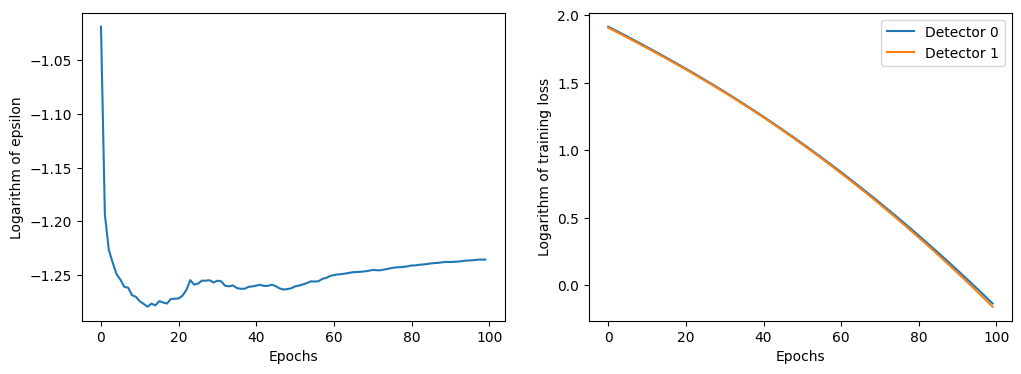

In [13]:
training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')

# Calculate centered position 'centroid'
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOFN_00_array, np.zeros((TOFN_00_array.shape[0])), hist_range = 0.8, nbins = nbins)  

error_V02 = abs((TOFN_02_array - centroid_V00[:, np.newaxis] + 0.2))
error_V20 = abs((TOFN_20_array - centroid_V00[:, np.newaxis] - 0.2))
error_V00 = abs((TOFN_00_array - centroid_V00[:, np.newaxis]))
error_V04 = abs((TOFN_04_array - centroid_V00[:, np.newaxis] + 0.4))
error_V40 = abs((TOFN_40_array - centroid_V00[:, np.newaxis] - 0.4))
Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)

MAE = np.mean(Error, axis = 1)
idx_min_MAE = np.where(MAE == np.min(MAE))[0][0]
print(idx_min_MAE, np.min(MAE))


# plot
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.plot(np.log10(MAE.astype('float64')))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')


plt.subplot(1,2,2)
plt.plot(np.log10(training_loss_dec0), label = 'Detector 0')
plt.plot(np.log10(training_loss_dec1), label = 'Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.legend()



V40: CENTROID(ns) = 0.397  FWHM(ns) = 0.157  std(ns) = 0.067
V82: CENTROID(ns) = 0.196  FWHM(ns) = 0.156  std(ns) = 0.066
V55: CENTROID(ns) = -0.000  FWHM(ns) = 0.152  std(ns) = 0.065
V28: CENTROID(ns) = -0.198  FWHM(ns) = 0.151  std(ns) = 0.064
V04: CENTROID(ns) = -0.396  FWHM(ns) = 0.152  std(ns) = 0.065


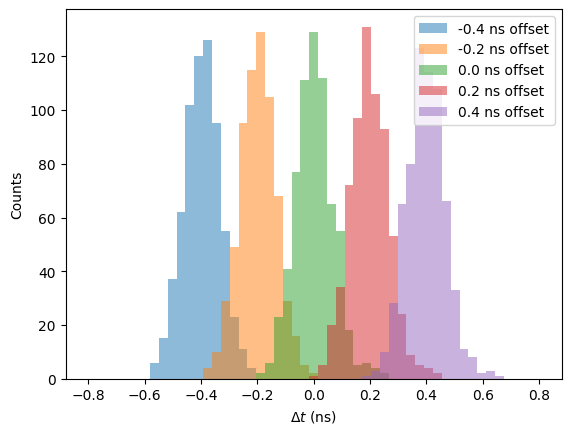

In [14]:
epoch = idx_min_MAE
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
HN, AN, x0N_V04, sigmaN_V04, FWHMN_V04 = plot_gaussian_and_get_params(TOFN_04_array[epoch,:], centroid_V00[epoch], range = 0.8, label = '-0.4 ns offset', nbins = nbins)
HN, AN, x0N_V28, sigmaN_V28, FWHMN_V28 = plot_gaussian_and_get_params(TOFN_02_array[epoch,:], centroid_V00[epoch], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
HN, AN, x0N_V55, sigmaN_V55, FWHMN_V55 = plot_gaussian_and_get_params(TOFN_00_array[epoch,:], centroid_V00[epoch], range = 0.8, label = '0.0 ns offset', nbins = nbins)
HN, AN, x0N_V82, sigmaN_V82, FWHMN_V82 = plot_gaussian_and_get_params(TOFN_20_array[epoch,:], centroid_V00[epoch], range = 0.8, label = '0.2 ns offset', nbins = nbins)
HN, AN, x0N_V40, sigmaN_V40, FWHMN_V40 = plot_gaussian_and_get_params(TOFN_40_array[epoch,:], centroid_V00[epoch], range = 0.8, label = '0.4 ns offset', nbins = nbins)

plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')



print('')
print("V40: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V40, FWHMN_V40, sigmaN_V40))
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))
print("V04: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V04, FWHMN_V04, sigmaN_V04))